In [1]:
import gzip
import struct
import datetime
import pandas as pd
import os
import sys
import time
from time import mktime as mktime

start_time = time.time()

In [2]:
class ITCH():

    def __init__(self):
        self.temp = []
        self.flag = None
        self.date = "01/30/19"
        if not os.path.exists(os.path.join('..', 'output')):
            os.makedirs(os.path.join('..', 'output'))
        self.dict = {b"S":11, b"R":38, b"H":24, b"Y":19, b"L":25, b"V": 34, b"W":11, b"K":27, b"A":35, b"F":39,b"E":30, b"C":35, b"X":22,b"D":18,b"U":34,b"P":43,b"Q":39,b"B":18,b"I":49,b"N":19,b"J":34}

    def get_binary(self, size):
        read = bin_data.read(size)
        return read

    def convert_time(self, stamp):
        datestamp= mktime(datetime.datetime.strptime(self.date, "%m/%d/%y").timetuple())
        stamp = stamp/1e9 + datestamp
        return stamp

    def cal_vwap(self, df):
        df['amount'] = df['price'] * df['volume']
        df['hour'] = df['time']-df['time']%3600
        df['time'] = pd.to_datetime(df['time'],unit='s',utc=True)
        df['hour'] = pd.to_datetime(df['hour'],unit='s',utc=True)
        df = df.groupby([df['hour'], df['symbol']], sort=False)['amount', 'volume'].sum()
        df['vwap'] = (df['amount'] / df['volume']).round(2)
        df = df.reset_index()
        df = df[['hour','symbol','vwap']]
        return df
        
    def trade_message(self, msg):
        msg_type = b'P'
        temp = struct.unpack('>4s6sQcI8cIQ', msg)
        new_msg = struct.pack('>s4s2s6sQsI8sIQ', msg_type, temp[0], b'\x00\x00', temp[1], temp[2],temp[3], temp[4],b''.join(list(temp[5:13])), temp[13], temp[14])
        value = struct.unpack('>sHHQQsI8sIQ', new_msg)
        value = list(value)
        value[3] = self.convert_time(value[3])
        value[7] = value[7].strip()
        value[8] = float(value[8])
        value[8] = value[8] / 10000
        return [value[3], value[7], value[8], value[6]], value[3]

    def progressBar(self, value, endvalue, bar_length=20):
        percent = float(value) / endvalue
        arrow = '-' * int(round(percent * bar_length)-1) + '>'
        spaces = ' ' * (bar_length - len(arrow))

        sys.stdout.write("\rPercent: [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))
        sys.stdout.flush()

In [3]:
if __name__ == '__main__':
    ## for open zipped file
#     bin_data = gzip.open(os.path.join('..', 'data', '01302019.NASDAQ_ITCH50.gz'), 'rb')
    path = "../data/01302019.NASDAQ_ITCH50"
    bin_data = open(path,'rb')
    
    ## initialize some parameters
    msg_header = ' '
    itch = ITCH()
    itch.date = "01/30/19"
    count = 0
    ## change message number to parse part of the data
    msg_num = 368366633 #float('inf') # 2000000
    countlen = 10**(len(str(msg_num))-1)

    ## start parse data by finding headers
    while msg_header and count <= msg_num:
        ## read next
        msg_header = bin_data.read(1)
        
        if msg_header in itch.dict.keys():
            message = itch.get_binary(itch.dict[msg_header])
            
            ## get trade message
            if msg_header == b"P":
                parsed_data, hour = itch.trade_message(message)
                itch.temp.append(parsed_data)
            
            ## counter and plot progress bar
            count += 1
            if count % (countlen/10) == 0:
                itch.progressBar(count,msg_num)
        else:
            pass
    print('\n total messages', count-1)
    
    ## create dataframe with trade messages
    df = pd.DataFrame(itch.temp, columns=['time', 'symbol', 'price', 'volume'])
    df['symbol']=df['symbol'].str.decode("utf-8")
    
    ## calculate vwap and output
    result = itch.cal_vwap(df)
    result.to_csv(os.path.join('..', 'output', 'stock_vwap.csv'), sep=' ', index=False)
    
    bin_data.close()
    print("\n --- %s seconds ---" % (time.time() - start_time))

Percent: [------------------->] 98%
 total messages 368366633

 --- 786.7073647975922 seconds ---


In [4]:
result.head()

,hour,symbol,vwap
0,2019-01-30 09:00:00+00:00,UGAZ,38.72
1,2019-01-30 09:00:00+00:00,SPY,264.33
2,2019-01-30 09:00:00+00:00,AMZN,1615.50
3,2019-01-30 09:00:00+00:00,AAPL,162.62
4,2019-01-30 09:00:00+00:00,TQQQ,42.71


In [5]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34019 entries, 0 to 34018
Data columns (total 3 columns):
hour      34019 non-null datetime64[ns, UTC]
symbol    34019 non-null object
vwap      34019 non-null float64
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 797.4+ KB


<IPython.core.display.Javascript object>


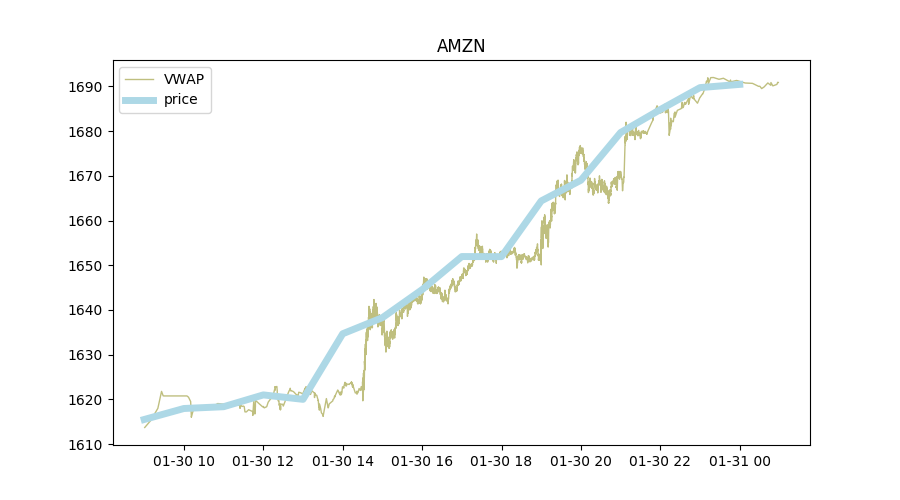

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## change stockname to see plot for different stocks
stockname='AMZN'
fig = plt.figure(figsize=(9,5))
plt.title(stockname)
x=result[result['symbol']==stockname]['hour']
y=result[result['symbol']==stockname]['vwap']

x2=df[df['symbol']==stockname]['time']
y2= df[df['symbol']==stockname]['price']

plt.plot(x2,y2, color='olive', linewidth=1, alpha=0.5)
plt.plot(x, y, color='lightblue', linewidth=5)

plt.legend(['VWAP', 'price', ],loc='upper left');
# plt.savefig('foo.png')
plt.show()